In [1]:
import torch
import torch.fft as fft

from torch_cfd.grids import *
from torch_cfd.equations import *
from torch_cfd.initial_conditions import *
from torch_cfd.finite_differences import *
from torch_cfd.forcings import *

import xarray
import seaborn as sns
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
n = 512
diam = 2 * torch.pi
dt = 1e-3
T = 10
max_velocity = 7
viscosity = 1e-3

dt = stable_time_step(dx=2 * torch.pi / n, dt=dt, viscosity=viscosity, max_velocity=max_velocity)
num_snapshots = 100
num_steps = int(T / dt)
record_iters = int(num_steps / num_snapshots)
peak_wavenumber = 4
scale = 1
random_state = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)


grid = Grid(shape=(n, n), domain=((0, diam), (0, diam)), device=device)

vort_init = vorticity_field(grid, peak_wavenumber, random_state=random_state)
vort_hat = fft.rfft2(vort_init.data).to(device)


forcing_fn = KolmogorovForcing(grid=grid, 
                                scale=scale, 
                                k=peak_wavenumber,
                                vorticity=True)

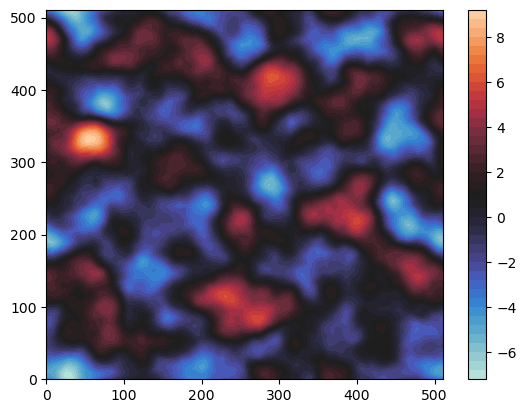

In [3]:
plt.contourf(vort_init.data.cpu(), cmap=sns.cm.icefire, levels=40)
plt.colorbar()
plt.show()

In [4]:
ns2d = NavierStokes2DSpectral(
    viscosity=viscosity, 
    grid=grid, 
    drag=0.1, 
    smooth=True, 
    forcing_fn=forcing_fn,
    solver=crank_nicolson_rk4
).to(device)

result = ns2d.get_trajectory(vort_hat, dt, T, 
                 record_every_steps=record_iters,
                 pbar=True
                 )
vort = fft.irfft2(result['vorticity']).cpu()
velocity = fft.irfft2(result['velocity']).cpu()
vort_t = fft.irfft2(result['vort_t']).cpu()

  0%|          | 0/11408 [00:00<?, ?it/s]

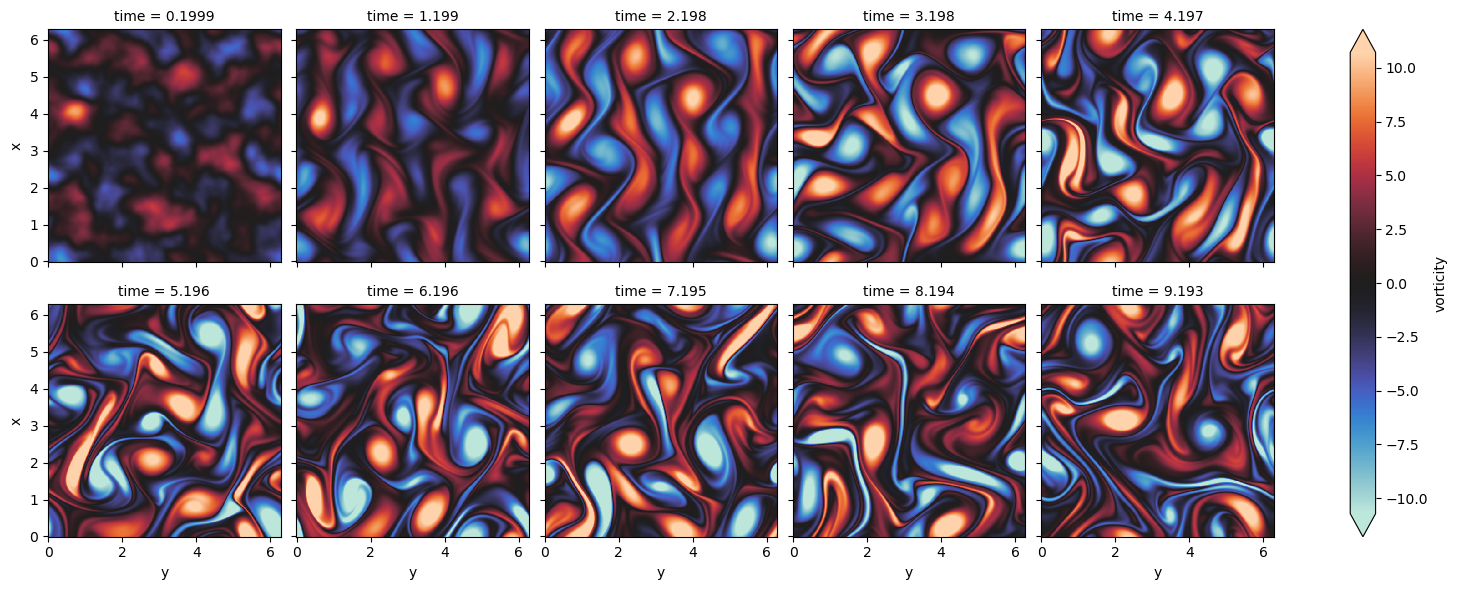

In [12]:
grid = torch.arange(n) * 2 * torch.pi / n # same for x and y
coords = {
  'time': record_iters * dt * torch.arange(len(vort)),
  'x': grid,
  'y': grid,
}

w_data = xarray.DataArray(
    torch.cat([vort_init.data[None, ...].cpu(), vort], dim=0)[:-1],
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='vorticity')

w_data['vorticity'].isel(time=slice(2,None)).thin(time=10).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

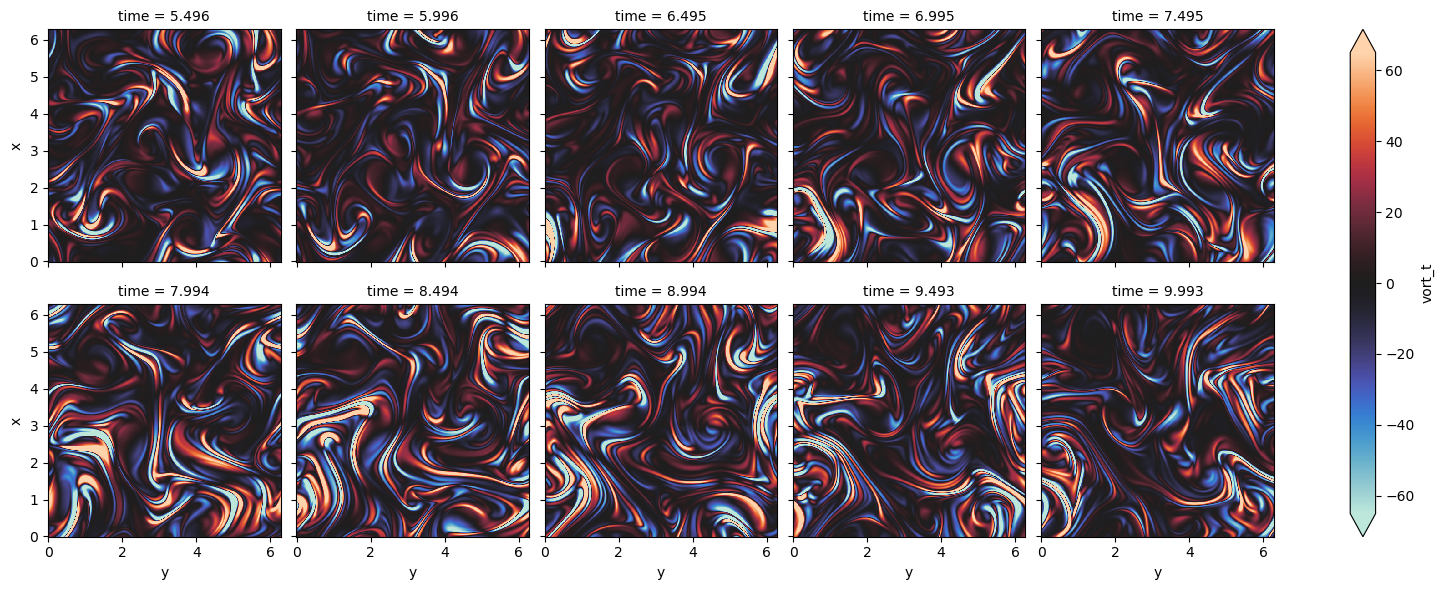

In [18]:
wt_data = xarray.DataArray(
    vort_t,
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='vort_t')
wt_data['vort_t'].isel(time=slice(55,None)).thin(time=5).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

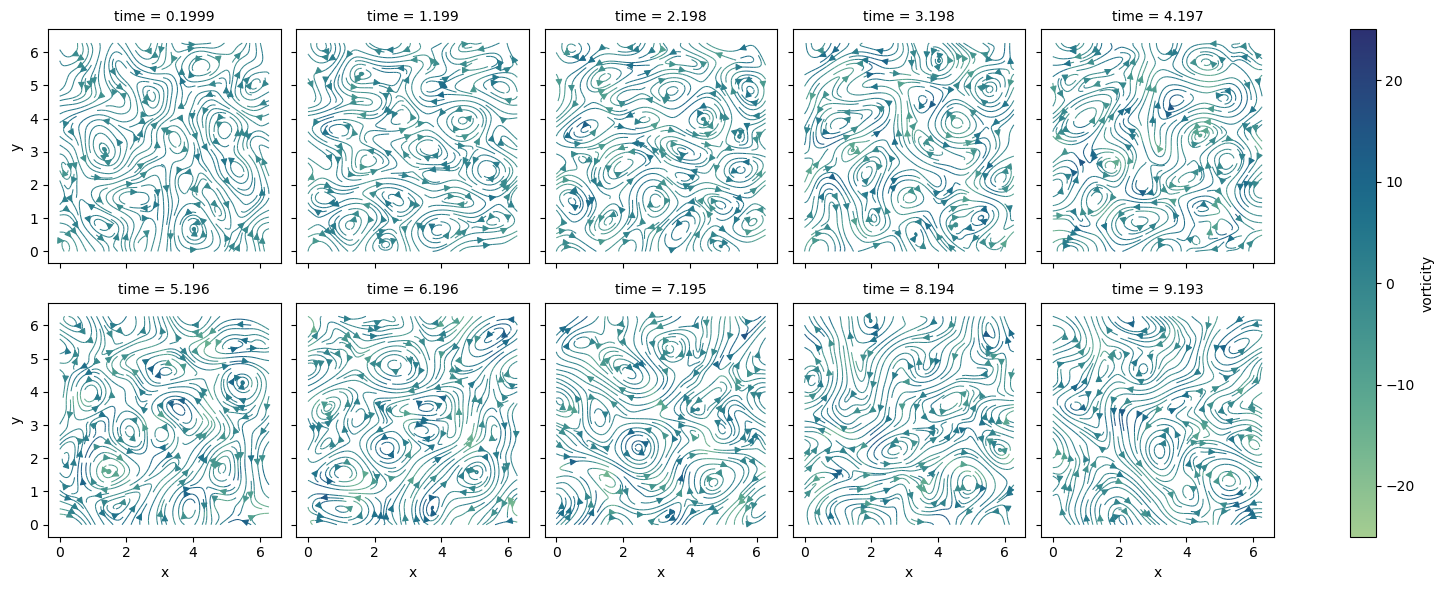

In [14]:
u_data = xarray.DataArray(
    velocity[:, 0],
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='u')

v_data = xarray.DataArray(
    velocity[:, 1],
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='v')

data = xarray.merge([u_data, v_data, w_data])

data.isel(time=slice(2,None)).thin(time=10).plot.streamplot(
    x="x",
    y="y",
    u="u",
    v="v",
    hue='vorticity',
    linewidth=0.75,
    col='time', 
    col_wrap=5,
    cmap=sns.cm.crest,
    vmin=-25,
    vmax=25,
    density=1.6,
    broken_streamlines=True
);